<img src="http://www.leadtraining.com.mt/excel-courses/images/time-series-forecaster.png" alt="Drawing" align="right" style="width: 100px;"/>
# Time series analysis with Python (*by Hrant Davtyan*)
<br/>

Time series analysis (also known as forecasting) comprises methods for analyzing time series data (data that includes the "time" variable). <br/>
There are several issues regarding the time series data that one needs to consider before moving to analytics:
- **Trend** - Persistent upward or downward pattern in data (can exists due to consumer behavior, population, economy, technology changes etc.)
- **Seasonality** - Regular up and down movements in data *[less than 1 year]* (can be the consequence of customs, weather or festival etc.)
- **Cyclicity** - Repeating up and down movements *[usually 2-10 years]* because of e.g. macroeconomic factors such as recession
- **Irregularity** - Irregular and unexpected random variation or unforeseen events in data (also known as whit noise)

Based on the above described points, we can roughly present our prediction as a function of those 4 components: **`Y = f(T, S, C, I)`** <br/>
The functional relationship of our prediction (Y) with the 4 components in general can be one of the 2 types:
- **Additive** - `Y = T + S + C + I`, which basically shows that the 4 components are independent,
- **Multiplicative** - `Y = T x S x C x I`, which basically shows that one of the components depends on the other.

There a re many different tyoes of models used for time series analysis, and the model selection depends on the type of the functional relationship described above (additive or multiplicative). However, there is one thing which is common to (almost) any model/method that one may apply (inddifferent from the type of functional relationship): [**stationarity**](https://en.wikipedia.org/wiki/Stationary_process). The time series data is ready for modelling/analytics if and only if it is stationary (as it is the main assumption lyeing behind most of the models). This means that any non-stationary data must be converted to stationary before applying any model/method to it. So what is this stationarity and why is it so important?

From the intuitive point of view, stationarity data is the one with no trend and seasonality. This is the reason that when converting the non-stationary data to a stationary the two main steps are **de-trending** and **de-seasonization**. <br/>
From the statistical point of view, stationarity is the property of time series data, for which all *important* parameters are constant over time (e.g. mean, variance, autocorrelation etc).

This notebook describes the main (starting) methods for time series analysis using the famous [AirPasseners dataset](https://www.analyticsvidhya.com/wp-content/uploads/2016/02/AirPassengers.csv). The latter provides monthly data on international airline passengers (in thousands) for the period of [1949,1961). In order to find the best curve which fits our dataset, we will overgo the following steps:

1. Understand stationarity (Trend and Seasonality) based on visualization
2. Apply Moving Average technique to fit a curve to our still non-stationary data
3. *To be added later, when covered in class*

The first things to do are to import the libraries necessary for performing the above mentioned tasks and to read the dataset in this notebook.

In [2]:
# importing necessary libraries
import pandas as pd # to present the data and apply MA technique
import numpy as np # to later perform mathematical transformation
import matplotlib.pyplot as plt # make plots
# to present plots inline with the code (on the same page)
%matplotlib inline

In [4]:
# reading the csv file from "Downloads" folder of my computer
data = pd.read_csv(r'C:\Users\Legion\Downloads\AirPassengers.csv')
# showing the first 5 observations of the dataset
data.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


As you can see from the DataFrame above, we have two columns: "Month", which presents the time series, and "Passengers", which presents the number of international passengers (in thousands) who travelled in that month. It is important to tell Python explicitly that "Month" is the column with time series data. Also, we can get rid of the very first column which provides the enumerations of DataFrame rows. To implement the latter and also to initialize "Month" as the time series component, we will import the same data again, but with several more parameters in the `read_csv` function.

In [5]:
# reading the data again with telling pandas to parse dates from the column "Month"
# and to make the column "Month" the index column (the very first one in Bold)
data = pd.read_csv(r'C:\Users\Legion\Downloads\AirPassengers.csv',parse_dates=['Month'], index_col='Month')
# showing the first 5 observations of the data
data.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


As you can see now, we got read of the very first column with row enumeration and now, the "Month" column is the very first, index column. As it is the index column, and also because it provides the time series component in the data, we can use it to select some observations as provided below.

In [6]:
# show all observations in 1949 (must be 12 observations - one per each month)
data['1949']

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135
1949-07-01,148
1949-08-01,148
1949-09-01,136


If you are interested in only several observations in a year or in several years (e.g. only summer, 1949) that is again doable in an easy manner, as described below.

In [7]:
# observations in summer, 1949, i.e. 06, 07 and 08 months of 1949
data['1949-06':'1949-08']

,Passengers
Month,
1949-06-01,135
1949-07-01,148
1949-08-01,148


Let's now plot the data and otherstand visually, whether there is a Trend/Seasonality or not.

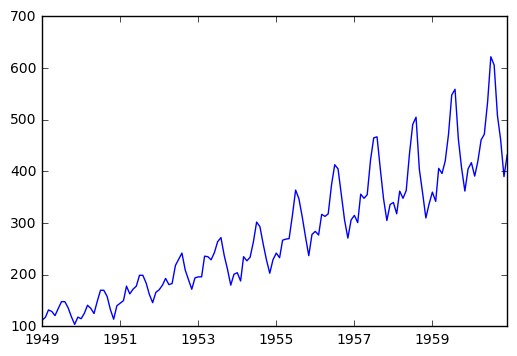

In [8]:
plt.plot(data)

From the plot above it is clearly visible that there is a quite significant positive (increasing) trend in the data. The repeating fluctiations above suggest that we have either Seasonality or Cyclisity in the dataset. Based on the facts that thoe fluctuations are happening on annual basis (so not more than a year) and that they are quite regular (expected), we conclude that Seasonality is the source of fluctuations (and not Cyclicity). Usually, rigorous statistical tests are used for determining the stationairty of the data (e.g. [Dickey-Fuller test](https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test)) as the graph alone may not convey enough information for decision-making. But for now we are satified with visualization only. <br/>
Another important conclusion that we can make from the plot above is that Trend and Seasonality **are not independent**: the fluctuations are becoming stronger/more volatile as the trend is increasing. Thus, we can conclude that for now, **multiplicative** models are more appropriate for our dataset. <br/>
Let's bear in mind the conclusion above, we will apply them in future. But for now, let's apply probably the simpliest and one of the most populat forecating technique called [**Moving Average (MA)**](https://en.wikipedia.org/wiki/Moving_average).This technique is also known as Rolling Mean, and it simply calculates the mean (arichmetic average) over a given period of time (e.g. average for a year, for a month, for a week etc) to fit the curve to the data and, in the end, make predictions. As our data on passengers is a monthly data, we will use annual averages (12-month average) for fitting purpose, as described below.

C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=12,center=False).mean()
  from ipykernel import kernelapp as app


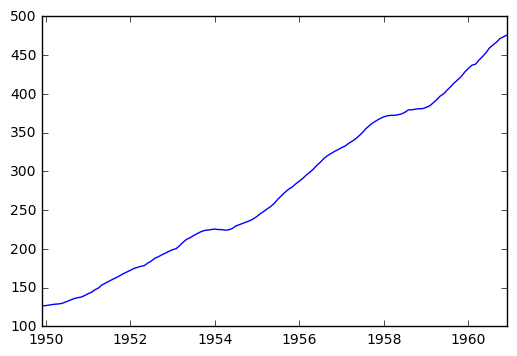

In [9]:
# use rolling_mean method from Pandas library to calculate MA(12), i.e. Moving average for each year
rolmean = pd.rolling_mean(data, window=12)
# plot the results
plt.plot(rolmean)

The plot above alone, is not quite informative, so let's plot it on our actualt data to make comparison easier

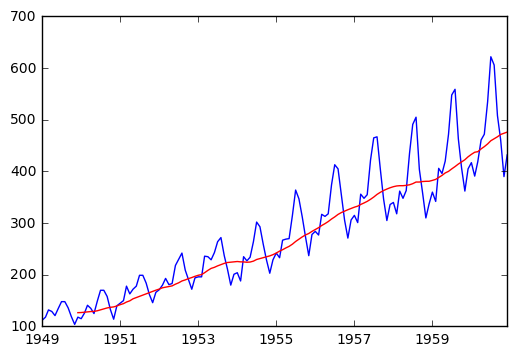

In [10]:
# plot original data in blue
orig = plt.plot(data, color='blue',label='Original')
# plot MA(12) fitted curve in read
mean = plt.plot(rolmean, color='red', label='Rolling Mean')

From the plot above we can infer that in average, our fitted line does a good job of describing the increasing trend. Yet, it fails when it comes predicting seasonal fluctuations. The techniques to deal with this issue will be dicussed during the next lecture. But for now, you may try to calculate and plot the Exponentially weighted moving average (more popular as [**Exponential Smoothing**](https://en.wikipedia.org/wiki/Exponential_smoothing)) on actual/original data and see wther it is doing better. The pandas function used for that purpose is ***`pd.ewma`***.

## To be continued...